In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import tensorflow_probability
from tensorflow_probability.python.internal.backend import jax as tf2jax
tfp = tensorflow_probability.experimental.substrates.jax
tfk = tfp.math.psd_kernels
import optax
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')
import sys; sys.path.insert(0, '..')
from riemannianvectorgp.sparse_gp import SparseGaussianProcess
from riemannianvectorgp.kernel import ScaledTFPKernel, FourierFeatures

In [2]:
def plot(x,y,f, samples=False):
    m = jnp.mean(f, axis=0)
    u = jnp.quantile(f, 0.975, axis=0)
    l = jnp.quantile(f, 0.025, axis=0)
    
    fig = plt.figure()
    # ax = fig.add_subplot(projection='polar')
    ax = fig.add_subplot()
    ax.scatter(x,y)
    ax.plot(x,m,linewidth=2)
    ax.fill_between(x, l, u, alpha=0.5)
    
    if samples:
        for i in range(f.shape[0]):
            ax.plot(x,f[i,:], color="gray",alpha=0.5)

class GlobalRNG:
    def __init__(self, seed: int = np.random.randint(2147483647)):
        self.key = jax.random.PRNGKey(seed)

    def __iter__(self):
        return self
    
    def __next__(self):
        (ret_key, self.key) = jr.split(self.key)
        return ret_key

In [3]:
rng = GlobalRNG()

In [4]:
x = jnp.expand_dims(jnp.linspace(-5,5,101), -1)
y = 2 * jnp.sin(x).T + jr.normal(next(rng), x.T.shape)/10

In [5]:
kernel = ScaledTFPKernel(tfk.ExponentiatedQuadratic,1,1)
kernel_params = kernel.init_params(next(rng))

In [6]:
gp = SparseGaussianProcess(kernel, 1, 1, 11, 67, 17)
(params, state) = gp.init_params_with_state(next(rng))

In [7]:
params = params._replace(inducing_locations = jnp.expand_dims(jnp.linspace(-5,5,11), -1))

In [8]:
state = gp.resample_prior_basis(params,state,next(rng))
state = gp.randomize(params,state,next(rng))

In [9]:
gp.loss(params,state,next(rng),x,y,x.shape[0])[0]

DeviceArray(135.94844, dtype=float32)

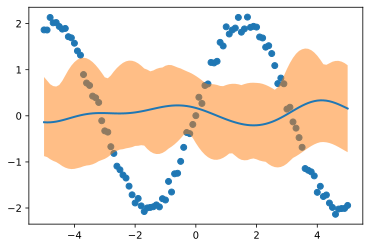

In [10]:
state = gp.randomize(params,state,next(rng))
plot(x[:,0],y[0,:],gp(params,state,x)[:,0,:])

In [11]:
opt = optax.chain(optax.scale_by_adam(b1=0.9, b2=0.999, eps=1e-8), optax.scale(-0.01))
opt_state = opt.init(params)

In [12]:
for i in range(200):
    ((train_loss,state),grads) = jax.value_and_grad(gp.loss, has_aux=True)(params,state,next(rng),x,y,x.shape[0])
    (updates,opt_state) = opt.update(grads, opt_state)
    params = optax.apply_updates(params,updates)
    if i <= 10 or i % 20 == 0: print(i,"Loss:",train_loss)

0 Loss: 111.91032
1 Loss: 127.93891
2 Loss: 120.213486
3 Loss: 119.66263
4 Loss: 113.7248
5 Loss: 111.17801
6 Loss: 100.29632
7 Loss: 88.13481
8 Loss: 94.75712
9 Loss: 92.738914
10 Loss: 95.26151
20 Loss: 90.475845
40 Loss: 41.302505
60 Loss: 20.188847
80 Loss: 5.701947
100 Loss: -12.671263
120 Loss: -32.94278
140 Loss: -46.68703
160 Loss: -64.15253
180 Loss: -80.11388


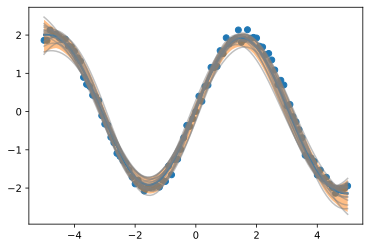

In [14]:
state = gp.randomize(params,state,next(rng))
plot(x[:,0],y[0,:],gp(params,state,x)[:,0,:], samples=True)